## Image Captioning - Multi-modal Models Application

### ViT- Vision Transformers+GPT2 Image Captioning

In [1]:
!pip3 install transformers datasets accelerate evaluate

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 81 kB 1.3 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

## Load Model and Tokenization

In [4]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [5]:
model = model.to(device)

In [6]:
max_length = 24
num_beams = 4

In [7]:
def get_caption(image_path):
  img = Image.open(image_path)
  if img.mode != "RGB":
    img = img.convert(mode="RGB")

  #extract features
  pixels = feature_extractor(images=[img], return_tensors="pt").pixel_values.to(device)
  #model inference generate the caption from the image using ViT model evaluation
  vocab_ids = model.generate(pixels,max_length=max_length,num_beams=num_beams)
  #decode ids into text
  output = tokenizer.batch_decode(vocab_ids, skip_special_tokens=True)
  result = [out.strip() for out in output]
  #display the input image and caption
  plt.imshow(img)
  plt.title(result)
  return result

## Make predictions

Now dowload and upload any image in colab notebook then get the caption

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


['a brown dog sitting on the edge of a pool of water']

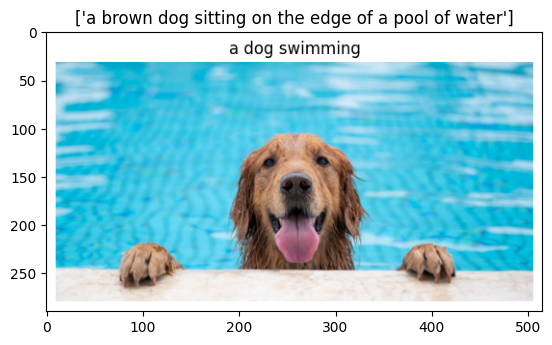

In [9]:
get_caption("dog_swimming.png")

['two photos of a man riding a surfboard in front of a painting']

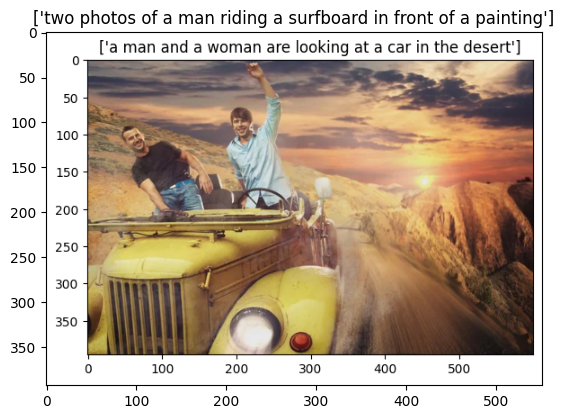

In [10]:
get_caption("men_driving.jpg")

# OpenAI Clip

In [11]:
from transformers import CLIPProcessor, CLIPModel

## Load OpenAI Clip - VIT model

### [OpenAI Clip](https://openai.com/research/clip)

CLIP can be applied to any visual classification benchmark by simply providing the names of the visual categories to be recognized, similar to the “zero-shot” capabilities of GPT-2 and GPT-3.

CLIP is a multi-modal vision and language model. It can be used for image-text similarity and for zero-shot image classification. CLIP uses a ViT like transformer to get visual features and a causal language model to get the text features. Both the text and visual features are then projected to a latent space with identical dimension. The dot product between the projected image and text features is then used as a similar score.

In [12]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [13]:
clip_model = clip_model.to(device)

In [14]:
image = Image.open("dog_swimming.png")

In [15]:
prob_captions = ["a cat swimming", "a dog swimming",'a dog and cat fighting']
inputs = processor(text=prob_captions, images=image, return_tensors="pt", padding=True)

In [16]:
inputs = inputs.to(device)

In [17]:
outputs = clip_model(**inputs)

In [18]:
# this is the image-text similarity score
similarity_ids = outputs.logits_per_image

In [19]:
probs_score = similarity_ids.softmax(dim=1)

In [20]:
probs_score

tensor([[9.9013e-04, 9.9901e-01, 2.5753e-06]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)

In [21]:
caption = prob_captions[torch.argmax(probs_score)]

(-0.5, 514.5, 289.5, -0.5)

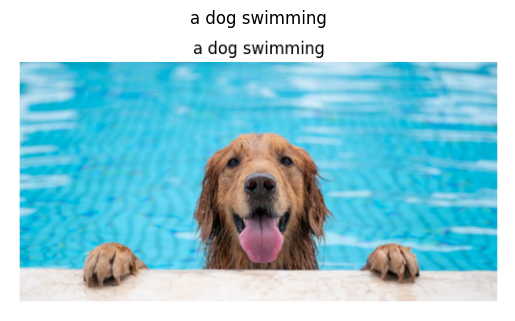

In [22]:
plt.imshow(image)
plt.title(caption)
plt.axis("off")

## Reference:

- [https://huggingface.co/nlpconnect/vit-gpt2-image-captioning](https://huggingface.co/nlpconnect/vit-gpt2-image-captioning)
- [https://huggingface.co/docs/transformers/model_doc/clip](https://huggingface.co/docs/transformers/model_doc/clip)